<a href="https://colab.research.google.com/github/trietp1253201581/NaturalLanguangeProcessing/blob/main/nlp_rnn_jigsaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xử lý ngôn ngữ tự nhiên với RNN - Phân loại bình luận độc hại

## Khám phá dữ liệu

In [ ]:
!ls .

data  jigsaw-toxic-comment-classification-challenge.zip  kaggle.json  lightning_logs  sample_data


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "."

In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

jigsaw-toxic-comment-classification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip jigsaw-toxic-comment-classification-challenge.zip -d data

Archive:  jigsaw-toxic-comment-classification-challenge.zip
replace data/sample_submission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd

In [ ]:
raw_df = pd.read_csv('data/train.csv.zip')
test_df = pd.read_csv('data/test.csv.zip')

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
for col in target_cols:
    print(f'{col}: {raw_df[col].sum()}')

toxic: 15294
severe_toxic: 1595
obscene: 8449
threat: 478
insult: 7877
identity_hate: 1405


## Preprocessing

### Tạo vocab

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
sample_comment = raw_df.comment_text.values[0]
sample_comment

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
sample_comment_tokens = tokenizer(sample_comment)
sample_comment_tokens[:10]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica']

In [ ]:
comment_tokens = raw_df['comment_text'].map(tokenizer)

In [ ]:
VOCAB_SIZE = 1500

In [ ]:
unk_token = '<unk>'
pad_token = '<pad>'

In [ ]:
vocab = build_vocab_from_iterator(comment_tokens, specials=[unk_token, pad_token], max_tokens=VOCAB_SIZE)

In [ ]:
vocab.set_default_index(vocab[unk_token])

In [ ]:
vocab['this']

18

In [ ]:
sample_indices = vocab.lookup_indices(sample_comment_tokens)
sample_indices[:10]

[667, 85, 3, 140, 142, 185, 39, 663, 0, 0]

In [ ]:
sample_comment_recovered = vocab.lookup_tokens(sample_indices)
sample_comment_recovered[:10]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 '<unk>',
 '<unk>']

### Train và valid split

<Axes: ylabel='Frequency'>

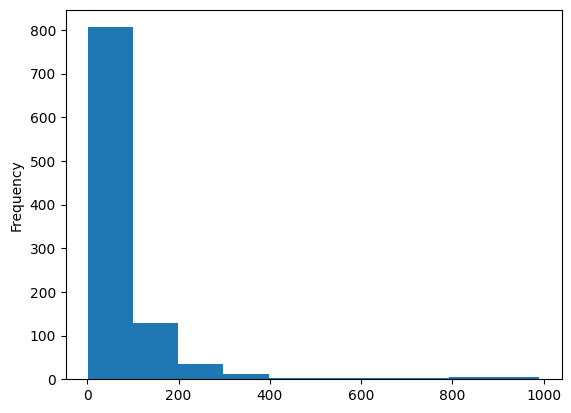

In [ ]:
raw_df.comment_text.sample(1000).map(tokenizer).map(len).plot(kind='hist')

In [ ]:
MAX_LENGTH = 150

In [ ]:
def pad_tokens(tokens):
    if len(tokens) < MAX_LENGTH:
        tokens = tokens + [pad_token] * (MAX_LENGTH - len(tokens))
    else:
        tokens = tokens[:MAX_LENGTH]
    return tokens

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
class JigsawDataset(Dataset):
    def __init__(self, df, is_test=False):
        self.df = df
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        comment = self.df['comment_text'].values[idx]
        tokens = pad_tokens(tokenizer(comment))
        input = torch.tensor(vocab.lookup_indices(tokens))
        if self.is_test:
            target = torch.tensor([0,0,0,0,0,0]).float()
        else:
            target = torch.tensor(self.df[target_cols].values[idx]).float()
        return input, target

In [ ]:
raw_ds = JigsawDataset(raw_df)

In [ ]:
raw_ds[0]

(tensor([ 667,   85,    3,  140,  142,  185,   39,  663,    0,    0, 1287,   96,
          329,   27,   57,    0,    9,   31,    0,    4,   61,    0,   21,   71,
            0,  158,    6,    0,   45,  130, 1167,    0,    0,    2,    8,   55,
           70,    9,   31,  253,    3,  369,   41,    3,   50,   38,  155,    6,
            9,   81,    0,   99,    2,    0,    2,    0,    2,    0,    2, 1122,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

In [ ]:
from torch.utils.data import random_split

In [ ]:
VAL_FRAC = 0.25

In [ ]:
train_ds, val_ds = random_split(raw_ds, [1-VAL_FRAC, VAL_FRAC])

In [ ]:
len(raw_ds), len(train_ds), len(val_ds)

(159571, 119679, 39892)

In [ ]:
test_ds = JigsawDataset(test_df, is_test=True)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE = 256

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*2, num_workers=2, pin_memory=True)

In [ ]:
for batch in train_dl:
    b_inputs, b_targets = batch
    print('b_input.shape', b_inputs.shape)
    print('b_targets.shape', b_targets.shape)

    break

b_input.shape torch.Size([256, 150])
b_targets.shape torch.Size([256, 6])


## Xây dựng mạng neuron hồi quy

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
emb_layer = nn.Embedding(VOCAB_SIZE, 256, padding_idx=vocab[pad_token])

In [ ]:
rnn_layer = nn.RNN(256, 128, 1, batch_first=True)

In [ ]:
for batch in train_dl:
    b_inputs, b_targets = batch
    print('b_input.shape', b_inputs.shape)
    print('b_targets.shape', b_targets.shape)

    emb_out = emb_layer(b_inputs)
    print('emb_out.shape', emb_out.shape)

    rnn_out, hn = rnn_layer(emb_out)
    print('rnn_out.shape', rnn_out.shape)
    print('hn.shape', hn.shape)
    print(rnn_out[:,0,:])
    print(rnn_out[:,-1,:])
    break

b_input.shape torch.Size([256, 150])
b_targets.shape torch.Size([256, 6])
emb_out.shape torch.Size([256, 150, 256])
rnn_out.shape torch.Size([256, 150, 128])
hn.shape torch.Size([1, 256, 128])
tensor([[ 0.4350, -0.7704,  0.3267,  ..., -0.8410,  0.2334, -0.8741],
        [-0.2885,  0.2391, -0.3860,  ...,  0.0037,  0.5155, -0.8878],
        [-0.3615,  0.8584, -0.5868,  ...,  0.2310, -0.6055,  0.7000],
        ...,
        [ 0.6121, -0.9092,  0.2332,  ..., -0.7122, -0.5013,  0.5201],
        [-0.8659,  0.3127, -0.2622,  ..., -0.2054,  0.3837, -0.9008],
        [-0.3615,  0.8584, -0.5868,  ...,  0.2310, -0.6055,  0.7000]],
       grad_fn=<SliceBackward0>)
tensor([[-0.0235,  0.2095, -0.1008,  ...,  0.0539,  0.0561, -0.0461],
        [-0.0235,  0.2095, -0.1008,  ...,  0.0539,  0.0561, -0.0461],
        [-0.0235,  0.2095, -0.1008,  ...,  0.0539,  0.0561, -0.0461],
        ...,
        [-0.0235,  0.2095, -0.1008,  ...,  0.0539,  0.0561, -0.0461],
        [-0.1264,  0.8780, -0.7228,  ...,  0.94

In [ ]:
!pip install pytorch-lightning --quiet

In [ ]:
import pytorch_lightning as pl
import numpy as np

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
class JigsawModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.emb_layer = nn.Embedding(VOCAB_SIZE, 256, padding_idx=vocab[pad_token])
        self.lstm = nn.LSTM(256, 128, 1, batch_first=True)
        self.fc = nn.Linear(128, 6)
        self.lr = 1e-3
        self.validation_step_outputs = []

    def forward(self, x):
        x = self.emb_layer(x)
        x, _ = self.lstm(x)
        x = F.relu(x[:, -1, :])
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = to_device(torch.sigmoid(outputs), get_default_device())
        loss = F.binary_cross_entropy(probs, targets)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = to_device(torch.sigmoid(outputs), get_default_device())
        loss = F.binary_cross_entropy(probs, targets)
        self.validation_step_outputs.append(loss.detach().cpu())
        return loss.item()

    def on_validation_epoch_end(self):
        avg_loss = np.mean(self.validation_step_outputs)
        print(f'Epoch {self.current_epoch} val loss: {avg_loss}')
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def predict_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        probs = to_device(torch.sigmoid(outputs), get_default_device())
        return probs

In [ ]:
get_default_device()

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, get_default_device())
val_dl = DeviceDataLoader(val_dl, get_default_device())

In [ ]:
model = to_device(JigsawModel(), get_default_device())

In [ ]:
trainer = pl.Trainer(max_epochs=3, accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | emb_layer | Embedding | 384 K  | train
1 | lstm      | LSTM      | 197 K  | train
2 | fc        | Linear    | 774    | train
------------------------------------------------
582 K     Trainable params
0         Non-trainable params
582 K     Total params
2.330     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0 val loss: 0.7020310163497925


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 val loss: 0.12214672565460205


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 val loss: 0.07466385513544083


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2 val loss: 0.06489503383636475


Ta đưa ra dự đoán

In [ ]:
test_preds = trainer.predict(model, dataloaders=test_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
test_preds = torch.cat(test_preds)
test_preds.shape

torch.Size([153164, 6])

In [ ]:
test_probs = torch.sigmoid(test_preds)
test_probs.shape

torch.Size([153164, 6])

In [ ]:
(test_probs > 0.6).int()

tensor([[1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0]], dtype=torch.int32)